In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader


load and prepare the data

In [2]:
LABEL_DIR = '/home/kuba/Documents/data/raw/face-detection-dataset/labels/train'
IMG_DIR = '/home/kuba/Documents/data/raw/face-detection-dataset/images/train'

with open('/home/kuba/projects/swvl/week01/single_face_train.txt', 'r') as file_names:
    names = file_names.readlines()
    train_img_paths = [ IMG_DIR + "/" + name.strip() + ".jpg" for name in names]
    train_label_paths = [ LABEL_DIR + "/" + name.strip() + ".txt" for name in names]


In [3]:
def process_and_pad_data(img_paths, label_paths, target_size=(224, 224)):
    image_tensors = []
    bboxes = []

    raw_imgs = []
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda t: t/255),  # Scale pixel values to 0..1
        transforms.Resize(target_size, antialias=True),  # Resize all images to same dimensions
    ])

    transform_raw = transforms.Compose([
        transforms.ToTensor()
    ])

    for f_img, f_label in tqdm(list(zip(img_paths, label_paths))):
        image = Image.open(f_img)
        raw_img = transform_raw(image)
        raw_imgs.append(raw_img)
        img_tensor = transform(image)
        if img_tensor.size()[0] == 1:
            img_tensor = img_tensor.repeat(3, 1, 1)

        
        with open(f_label, 'r') as f:
            label = f.readline().strip()
            bbox = torch.tensor([float(x) for x in label.split()])[1:]
        
        if img_tensor.size()[0] == 3:
            image_tensors.append(img_tensor)
            bboxes.append(bbox)
    
    
    X = torch.stack(image_tensors)  
    y = torch.stack(bboxes)
    # raw_imgs = torch.stack(raw_imgs)
    
    return X, y, raw_imgs

X, y, raw_imgs = process_and_pad_data(train_img_paths, train_label_paths)
print("Train images shape:", X.shape)
print("Train bboxes shape:", y.shape)

100%|██████████| 5791/5791 [01:01<00:00, 93.76it/s] 


Train images shape: torch.Size([5789, 3, 224, 224])
Train bboxes shape: torch.Size([5789, 4])


In [4]:
train_dataset = TensorDataset(X[:100], y[:100])

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32)

init the model which is the same as in notebook 00 of week1

In [6]:
#same bacuise we go 3x3, 3x3, 3x3
class BasicBlockSame(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=stride, bias=False)
        self.bnorm0 = nn.BatchNorm2d(out_channels)

        self.conv1 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bnorm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bnorm2 = nn.BatchNorm2d(out_channels)

        self.shortcut  = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1, stride=stride)

    def forward(self, x):
        residual = x
        x = self.conv0(x)
        x = self.bnorm0(x)
        x = nn.functional.relu(x)

        x = self.conv1(x)
        x = self.bnorm1(x)
        x = nn.functional.relu(x)

        x = self.conv2(x)
        x = self.bnorm2(x)

        x += self.shortcut(residual)
        x = nn.functional.relu(x)
        return x


#varying bacuise we go 3x3, 1x1, 3x3
class BasicBlockVarying(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1 ):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=stride, bias=False)
        self.bnorm0 = nn.BatchNorm2d(out_channels)

        self.conv1 = nn.Conv2d(out_channels, out_channels, 1, bias=False)
        self.bnorm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bnorm2 = nn.BatchNorm2d(out_channels)

        self.shortcut  = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1, stride=stride)

    def forward(self, x):
        residual = x
        x = self.conv0(x)
        x = self.bnorm0(x)
        x = nn.functional.relu(x)

        x = self.conv1(x)
        x = self.bnorm1(x)
        x = nn.functional.relu(x)

        x = self.conv2(x)
        x = self.bnorm2(x)



        x += self.shortcut(residual)
        x = nn.functional.relu(x)
        return x


class SENBlock(nn.Module):
    def __init__(self, in_channels, r=16):
        super().__init__()
        self.sq = nn.AdaptiveAvgPool2d(1)
        self.fc0 = nn.Linear(in_channels, int(in_channels/r))
        self.fc1 = nn.Linear(int(in_channels/r), in_channels)

    def forward(self, x):
        residual = x
        batch_size, channels, _, _ = residual.size()
        x = self.sq(x).squeeze()
        x = self.fc0(x)
        x = nn.functional.relu(x)

        x = self.fc1(x)
        x = nn.functional.sigmoid(x).view(batch_size, channels, 1, 1)
        
        x = residual * x
        return x

In [7]:
class SenResNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.c0 = nn.Conv2d(3,32,3,padding=1)
        self.maxp = nn.MaxPool2d(2,2)
        self.resblock0 = BasicBlockSame(32,64, stride=2)
        self.resblock1 = BasicBlockSame(64,64)
        self.resblock2 = BasicBlockSame(64,64)
        self.sen0 = SENBlock(64)

        self.resblock3  = BasicBlockVarying(64,128, stride=2)
        self.resblock4  = BasicBlockVarying(128,128)
        self.resblock5  = BasicBlockVarying(128,128)
        self.resblock6  = BasicBlockVarying(128,128)
        self.sen1 = SENBlock(128)

        self.resblock7  = BasicBlockVarying(128,256, stride=2)
        self.resblock8  = BasicBlockVarying(256,256)
        self.resblock9  = BasicBlockVarying(256,256)
        self.resblock10  = BasicBlockVarying(256,256)
        self.resblock11  = BasicBlockVarying(256,256)
        self.resblock12  = BasicBlockVarying(256,256)
        self.sen2 = SENBlock(256)

        self.resblock13 = BasicBlockVarying(256,512, stride=2)
        self.resblock14  = BasicBlockVarying(512,512)
        self.resblock15 = BasicBlockVarying(512,512)

        self.c1 = nn.Conv2d(512, 1024, 3, padding=1 , stride=2)
        self.c2 = nn.Conv2d(1024, 512, 1, padding=1)
        self.gap0 = nn.AdaptiveAvgPool2d(1)
        self.fc0 = nn.Linear(512, 4)



    def forward(self, x):
        x = self.c0(x)
        x = self.maxp(x)

        x = self.resblock0.forward(x)
        x = self.resblock1.forward(x)
        x = self.resblock2.forward(x)
        x = self.sen0.forward(x)

        x = self.resblock3.forward(x)
        x = self.resblock4.forward(x)
        x = self.resblock5.forward(x)
        x = self.resblock6.forward(x)
        x = self.sen1.forward(x)

        x = self.resblock7.forward(x)
        x = self.resblock8.forward(x)
        x = self.resblock9.forward(x)
        x = self.resblock10.forward(x)
        x = self.resblock11.forward(x)
        x = self.resblock12.forward(x)
        x = self.sen2.forward(x)

        x = self.resblock13.forward(x)
        x = self.resblock14.forward(x)
        x = self.resblock15.forward(x)
        
        x = self.c1(x)
        x = self.c2(x)
        x = self.gap0(x).squeeze()
        x = self.fc0(x)


        return x

In [8]:
model = SenResNet()


In [9]:
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [10]:
lossi = []

In [11]:
device = 'cuda'
model = model.to(device)

In [12]:
for epoch in tqdm(range(100)):
    loss_total = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        loss = criterion(logits, y_batch.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()

    lossi.append(loss_total / len(train_loader))

100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


([<matplotlib.lines.Line2D at 0x7dd9da531120>], '0.0621096734')

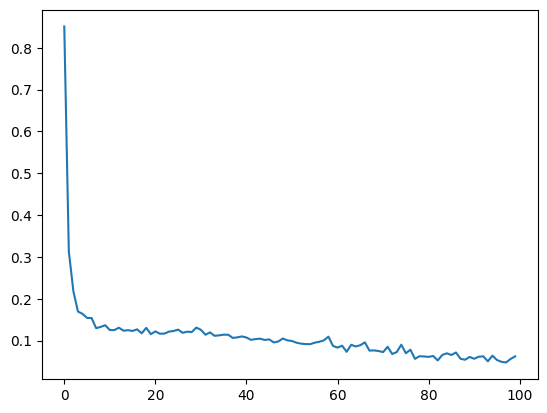

In [13]:
plt.plot(lossi), f"{lossi[-1]:.10f}"

In [14]:
def calculate_center_coordinates(im, bbox_pred):
    center_x_pxl = int(len(im[0]) * bbox_pred[0]) #img width * percent x
    center_y_pxl = int(len(im) * bbox_pred[1]) #img height * percent y
    return center_x_pxl, center_y_pxl

def calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred):
    half_width = int(len(im[0]) * (bbox_pred[2] / 2))
    half_height = int(len(im) * (bbox_pred[3] / 2))
    
    return {
        'y0': center_y_pxl + half_height,
        'y1': center_y_pxl - half_height,
        'x0': center_x_pxl + half_width,
        'x1': center_x_pxl - half_width,
        'xmin': center_x_pxl - half_width,
        'xmax': center_x_pxl + half_width,
        'ymin': center_y_pxl - half_height,
        'ymax': center_y_pxl + half_height
    }

def visualize_prediction(img_tensor, bbox_pred, epoch):
    im = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
    
    center_x_pxl, center_y_pxl = calculate_center_coordinates(im, bbox_pred)
    coords = calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred)
    
    plt.imshow(im)
    plt.plot(center_x_pxl, center_y_pxl, 'ro')
    
    # horizontal lines
    plt.hlines(coords['y0'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
    plt.hlines(coords['y1'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
    
    # vertical lines
    plt.vlines(coords['x0'], coords['ymin'], coords['ymax'], colors='red')
    plt.vlines(coords['x1'], coords['ymin'], coords['ymax'], colors='red')
    
    plt.title(f'Epoch {epoch}')
    plt.show()

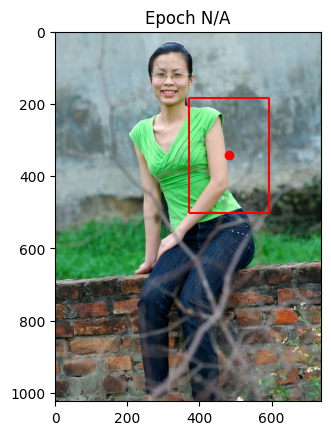

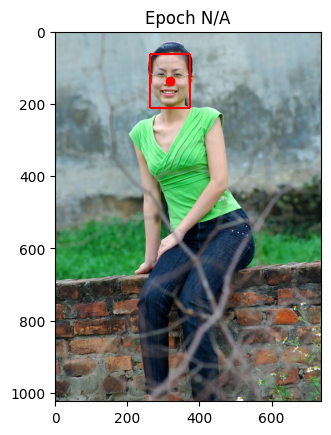

0.18378718197345734

In [15]:
img_num = 2
model = model.cpu()
logits = model(X[img_num].cpu().unsqueeze(dim=0))
visualize_prediction(raw_imgs[img_num], logits, 'N/A')
visualize_prediction(raw_imgs[img_num], y[img_num], 'N/A')

criterion(logits,y[img_num].cpu()).item()

We cant have such low loss for  such a bad prediction we must use better loss funtion for our use case